# Dacon

https://dacon.io/competitions/official/235608/overview/

1. 배경

빛을 응용한 뇌 내 성분 검사는 피부 상처 없이 다양한 성분 정보를 알 수 있습니다. 이는 뇌 활동 연구를 위해 신경영상을 얻을 수 있는 방법으로, 바늘(전극)을 찔러 넣는 방법인 뇌전도 검사를 대체할 방안으로 각광 받고 있습니다.
제공된 데이터로 뇌 내 성분 분석 알고리즘을 만들어 주세요. 여러분의 노력으로 따끔한 바늘에서 멀어질 수 있습니다!

2. 목표

신경영상 및 뇌 활동 검사를 위해 제공된 모의 시뮬레이션 데이터를 기반으로 하는 AI 알고리즘 개발

- 해결해야 하는 문제
    - 광원, 측정 스펙트럼으로부터 뇌 내 성분 농도 산출
- train.csv(10MB)
    - id : 구분자
    - rho : 측정 거리 (단위: mm)
    - src : 광원 스펙트럼 (650 nm ~ 990 nm)
    - dst : 측정 스펙트럼 (650 nm ~ 990 nm)
    - hhb : 디옥시헤모글로빈 농도
    - hbo2 : 옥시헤모글로빈 농도
    - ca : 칼슘 농도
    - na : 나트륨 농도
- test.csv(10MB)
    - id : 구분자
    - rho : 측정 거리 (단위: mm)
    - src : 광원 스펙트럼 (650 nm ~ 990 nm)
    - dst : 측정 스펙트럼 (650 nm ~ 990 nm)
- sample_submission.csv(1MB)
    - hhb : 디옥시헤모글로빈 농도
    - hbo2 : 옥시헤모글로빈 농도
    - ca : 칼슘 농도
    - na : 나트륨 농도

> 헤모글로빈은 4개의 헴을 가지고 헴 하나는 산소 분자 하나와 결합할 수 있으므로 헤모글로빈 하나는 총 4개의 산소 분자와 결합할 수 있다.  
> 산소헤모글로빈(oxyhemoglobin)은 헤모글로빈에 산소가 포화된(saturated) 결합물이다.  
> 산소로 포화되지 않은(desaturated with oxygen) 헤모글로빈은 deoxyhemoglobin이라고 한다.  
> 결합 산소가 없는 헤모글로빈은 deoxygenated hemoglobin이라고 한다.  
> https://ko.wikipedia.org/wiki/%ED%97%A4%EB%AA%A8%EA%B8%80%EB%A1%9C%EB%B9%88

> 헤모글로빈은 철(Fe)을 품고 있는 헴(heme) 그리고 단백질 사슬의 일종인 글로빈(globin)으로 구성되어 있다.  
> 형태는 4개의 글로빈 단백질 사슬이 각각 하나씩의 헴(heme)을 둘러싸고 있는 모양이다.  
> 각 헴의 중심에 있는 철(Fe) 원자는 1개의 산소와 결합할 수 있으므로, 헤모글로빈 한 분자는 4개의 산소와 결합 할 수 있는 잠재력을 가지고 있다.  
> http://health.chosun.com/healthyLife/column_view.jsp?idx=9397


> Besides, the NIRS signal depends on the different optical properties of HbO2 and HHb, and measures the blood volume and blood oxygenation regulation supporting the neural activity

In [1]:
%matplotlib inline
%reload_ext lab_black

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

In [3]:
train_df.shape

(10000, 76)

In [4]:
test_df.shape

(10000, 72)

In [5]:
train_df.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,...,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,...,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,...,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,...,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN,11.97,4.41,10.78,2.42


In [6]:
test_df.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,10000,15,0.15406,0.23275,0.30977,0.42949,0.51264,0.62558,0.74340,0.85418,...,0.000000e+00,0.000000e+00,1.432248e-14,0.000000e+00,0.000000e+00,6.332117e-15,1.429966e-14,0.000000e+00,NaN,7.320236e-14
1,10001,15,0.48552,0.56939,0.67575,0.79089,0.85114,0.92581,0.98071,0.98177,...,1.036013e-13,NaN,2.830975e-14,1.114337e-13,4.825731e-14,NaN,2.282485e-14,7.348414e-14,1.259055e-13,2.349874e-13
2,10002,10,0.46883,0.56085,0.62442,0.73172,0.81724,0.91517,0.94801,0.99108,...,NaN,NaN,NaN,NaN,1.569208e-11,6.242378e-12,NaN,1.219010e-11,NaN,NaN
3,10003,10,0.06905,0.07517,0.10226,0.14905,0.16182,0.19659,0.26085,0.36753,...,1.651177e-11,7.282747e-12,5.010879e-12,NaN,1.571023e-11,0.000000e+00,0.000000e+00,3.304247e-12,4.106134e-11,NaN
4,10004,25,0.00253,0.00757,0.01649,0.00128,0.00000,0.00000,0.00105,0.01975,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.732057e-17,4.110605e-17,0.000000e+00,0.000000e+00,1.910775e-16,2.215673e-15


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 76 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       10000 non-null  int64  
 1   rho      10000 non-null  int64  
 2   650_src  10000 non-null  float64
 3   660_src  10000 non-null  float64
 4   670_src  10000 non-null  float64
 5   680_src  10000 non-null  float64
 6   690_src  10000 non-null  float64
 7   700_src  10000 non-null  float64
 8   710_src  10000 non-null  float64
 9   720_src  10000 non-null  float64
 10  730_src  10000 non-null  float64
 11  740_src  10000 non-null  float64
 12  750_src  10000 non-null  float64
 13  760_src  10000 non-null  float64
 14  770_src  10000 non-null  float64
 15  780_src  10000 non-null  float64
 16  790_src  10000 non-null  float64
 17  800_src  10000 non-null  float64
 18  810_src  10000 non-null  float64
 19  820_src  10000 non-null  float64
 20  830_src  10000 non-null  float64
 21  840_src  1000

In [8]:
train_df.describe()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,7.982000e+03,7.987000e+03,7.992000e+03,7.931000e+03,8.081000e+03,8.013000e+03,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,17.568000,0.180212,0.203529,0.229804,0.259158,0.289975,0.322244,0.354101,0.384492,...,7.511190e-11,4.270426e-11,2.498465e-11,4.047717e-11,1.153774e-10,2.364072e-10,7.990686,4.009146,9.019226,3.042651
std,2886.89568,5.595847,0.272859,0.288661,0.306340,0.324849,0.342362,0.357700,0.370451,0.379054,...,3.831916e-10,2.293432e-10,1.639150e-10,2.134495e-10,5.179299e-10,1.058272e-09,2.970818,0.997828,2.979453,1.881872
min,0.00000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.080000,0.000000,0.000000
25%,2499.75000,15.000000,0.007318,0.009520,0.011270,0.013728,0.016350,0.019510,0.026217,0.037235,...,1.574964e-19,0.000000e+00,0.000000e+00,0.000000e+00,5.669218e-18,6.574627e-17,5.990000,3.330000,7.000000,1.640000
50%,4999.50000,20.000000,0.052025,0.064600,0.078565,0.095355,0.119635,0.148590,0.181905,0.219260,...,6.566552e-16,8.391564e-17,2.525680e-17,1.231848e-16,3.395726e-15,1.717923e-14,8.010000,4.010000,8.990000,2.980000
75%,7499.25000,25.000000,0.221117,0.276952,0.339075,0.417478,0.510915,0.607150,0.698085,0.781490,...,9.503366e-13,3.186890e-13,1.234955e-13,2.958971e-13,2.392410e-12,6.942183e-12,10.010000,4.700000,11.020000,4.330000
max,9999.00000,25.000000,1.019990,1.019970,1.019930,1.019880,1.020000,1.019970,1.019970,1.019940,...,1.343132e-08,6.461523e-09,5.773867e-09,5.529940e-09,1.013262e-08,2.682289e-08,21.590000,7.690000,20.070000,10.310000


In [9]:
train_df.isnull().sum().sort_values(ascending=False).head(40)

820_dst    2091
750_dst    2071
970_dst    2069
790_dst    2059
890_dst    2059
760_dst    2050
720_dst    2046
840_dst    2045
920_dst    2038
910_dst    2030
800_dst    2026
870_dst    2020
940_dst    2018
850_dst    2014
950_dst    2013
860_dst    2010
960_dst    2008
730_dst    2006
690_dst    2003
900_dst    1999
770_dst    1994
740_dst    1993
810_dst    1990
660_dst    1988
990_dst    1987
930_dst    1978
680_dst    1975
880_dst    1968
700_dst    1966
830_dst    1965
650_dst    1948
710_dst    1946
780_dst    1945
670_dst    1931
980_dst    1919
830_src       0
730_src       0
810_src       0
800_src       0
790_src       0
dtype: int64

In [10]:
test_df.isnull().sum().sort_values(ascending=False).head(40)

880_dst    2080
870_dst    2063
830_dst    2058
710_dst    2043
820_dst    2042
730_dst    2038
810_dst    2034
790_dst    2030
650_dst    2026
960_dst    2020
780_dst    2020
670_dst    2015
720_dst    2014
980_dst    2011
860_dst    2008
680_dst    2006
850_dst    2005
930_dst    2000
760_dst    2000
940_dst    1999
740_dst    1999
890_dst    1996
690_dst    1985
920_dst    1981
900_dst    1976
970_dst    1976
990_dst    1970
750_dst    1965
800_dst    1961
660_dst    1960
770_dst    1956
950_dst    1949
700_dst    1948
840_dst    1947
910_dst    1919
810_src       0
760_src       0
740_src       0
750_src       0
790_src       0
dtype: int64

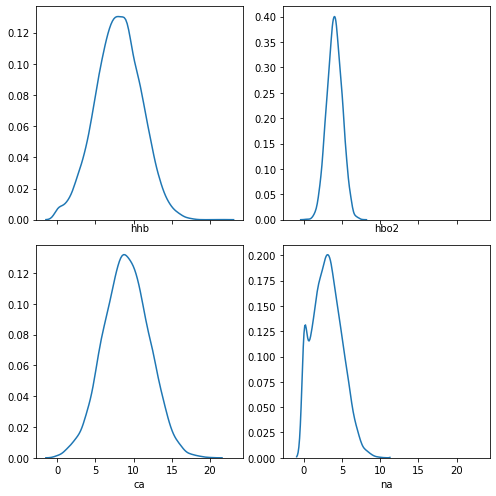

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
# sns.despine(left=True)

sns.distplot(train_df["hhb"], hist=False, ax=axes[0, 0])
sns.distplot(train_df["hbo2"], hist=False, ax=axes[0, 1])
sns.distplot(train_df["ca"], hist=False, ax=axes[1, 0])
sns.distplot(train_df["na"], hist=False, ax=axes[1, 1])

# plt.setp(axes, yticks=[])
plt.tight_layout()

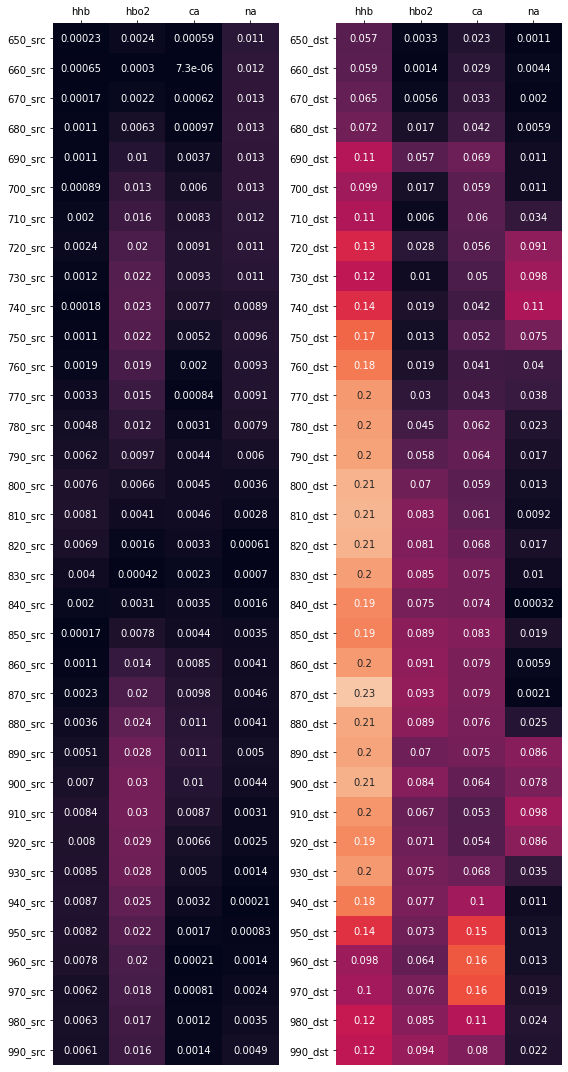

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 15))

sns.heatmap(
    train_df.corr().loc["650_src":"990_src", "hhb":].abs(),
    vmin=0.0,
    vmax=0.1,
    annot=True,
    cbar=False,
    ax=axes[0],
)
sns.heatmap(
    train_df.corr().loc["650_dst":"990_dst", "hhb":].abs(),
    vmin=0.0,
    vmax=0.25,
    annot=True,
    cbar=False,
    ax=axes[1],
)

axes[0].xaxis.tick_top()
axes[1].xaxis.set_ticks_position("top")
plt.tight_layout()

In [13]:
train_df["na"].sort_values(ascending=False)

9387    10.31
8668     9.91
5850     9.80
461      9.75
555      9.57
        ...  
3771     0.00
6601     0.00
9697     0.00
6595     0.00
4952     0.00
Name: na, Length: 10000, dtype: float64

In [14]:
train_df.loc["650_src":"990_src"]

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
6510,6510,15,0.23973,0.28679,0.39933,0.47631,0.56211,0.67326,0.75918,0.83323,...,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,5.59,3.74,8.38,2.76
6511,6511,15,0.01297,0.00830,0.01736,0.00000,0.00572,0.00500,0.00050,0.00000,...,2.417809e-11,1.201630e-11,NaN,NaN,4.193957e-11,1.155083e-10,3.18,3.19,6.43,3.50
6512,6512,10,0.01995,0.00131,0.01657,0.00000,0.01237,0.01636,0.01082,0.00452,...,1.198393e-10,8.088448e-11,8.317256e-11,1.535706e-10,4.961917e-10,1.091786e-09,11.13,5.01,8.72,3.03
6513,6513,15,0.08258,0.13069,0.14099,0.17100,0.23237,0.29092,0.31858,0.38068,...,4.002183e-13,4.786254e-15,8.313620e-14,1.150338e-13,8.852564e-13,3.662958e-12,7.63,3.33,11.03,4.47
6514,6514,25,0.00358,0.02070,0.00000,0.03411,0.04412,0.03049,0.05528,0.08619,...,1.251821e-15,1.243903e-16,4.997730e-16,2.926185e-16,1.211387e-15,3.116260e-15,0.62,5.01,4.49,4.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9905,9905,15,0.02767,0.03437,0.01293,0.06131,0.05304,0.11323,0.15047,0.19018,...,NaN,0.000000e+00,6.969991e-14,1.317494e-13,0.000000e+00,1.305323e-13,1.69,5.60,9.79,3.27
9906,9906,25,0.09283,0.13389,0.10809,0.13852,0.13664,0.18772,0.20170,0.22321,...,NaN,6.825208e-17,7.676876e-17,2.522223e-17,2.529005e-16,1.134657e-15,2.71,4.52,6.20,6.13
9907,9907,10,0.83813,0.92256,0.98090,1.01876,0.96060,0.88702,0.78035,0.66342,...,5.904800e-14,NaN,NaN,NaN,0.000000e+00,9.918261e-13,10.19,3.64,7.72,0.37
9908,9908,15,0.00520,0.00395,0.00000,0.00000,0.00000,0.01169,0.00000,0.00882,...,1.421897e-14,NaN,0.000000e+00,0.000000e+00,0.000000e+00,3.823051e-14,5.79,5.84,17.86,4.77


In [15]:
train_df.loc["650_dst":"990_dst"]

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
6510,6510,15,0.23973,0.28679,0.39933,0.47631,0.56211,0.67326,0.75918,0.83323,...,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,5.59,3.74,8.38,2.76
6511,6511,15,0.01297,0.00830,0.01736,0.00000,0.00572,0.00500,0.00050,0.00000,...,2.417809e-11,1.201630e-11,NaN,NaN,4.193957e-11,1.155083e-10,3.18,3.19,6.43,3.50
6512,6512,10,0.01995,0.00131,0.01657,0.00000,0.01237,0.01636,0.01082,0.00452,...,1.198393e-10,8.088448e-11,8.317256e-11,1.535706e-10,4.961917e-10,1.091786e-09,11.13,5.01,8.72,3.03
6513,6513,15,0.08258,0.13069,0.14099,0.17100,0.23237,0.29092,0.31858,0.38068,...,4.002183e-13,4.786254e-15,8.313620e-14,1.150338e-13,8.852564e-13,3.662958e-12,7.63,3.33,11.03,4.47
6514,6514,25,0.00358,0.02070,0.00000,0.03411,0.04412,0.03049,0.05528,0.08619,...,1.251821e-15,1.243903e-16,4.997730e-16,2.926185e-16,1.211387e-15,3.116260e-15,0.62,5.01,4.49,4.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9905,9905,15,0.02767,0.03437,0.01293,0.06131,0.05304,0.11323,0.15047,0.19018,...,NaN,0.000000e+00,6.969991e-14,1.317494e-13,0.000000e+00,1.305323e-13,1.69,5.60,9.79,3.27
9906,9906,25,0.09283,0.13389,0.10809,0.13852,0.13664,0.18772,0.20170,0.22321,...,NaN,6.825208e-17,7.676876e-17,2.522223e-17,2.529005e-16,1.134657e-15,2.71,4.52,6.20,6.13
9907,9907,10,0.83813,0.92256,0.98090,1.01876,0.96060,0.88702,0.78035,0.66342,...,5.904800e-14,NaN,NaN,NaN,0.000000e+00,9.918261e-13,10.19,3.64,7.72,0.37
9908,9908,15,0.00520,0.00395,0.00000,0.00000,0.00000,0.01169,0.00000,0.00882,...,1.421897e-14,NaN,0.000000e+00,0.000000e+00,0.000000e+00,3.823051e-14,5.79,5.84,17.86,4.77


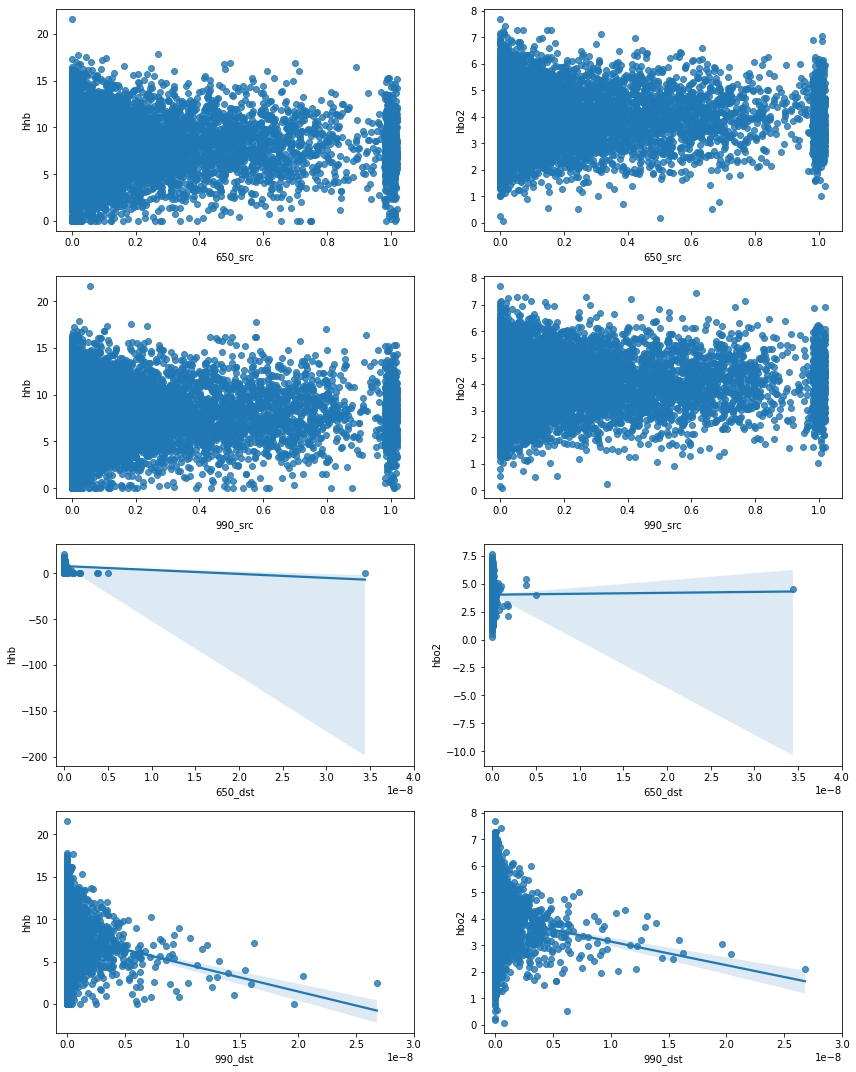

In [16]:
fig, axes = plt.subplots(4, 2, figsize=(12, 15))

sns.regplot(x="650_src", y="hhb", data=train_df, fit_reg=False, ax=axes[0, 0])
sns.regplot(x="650_src", y="hbo2", data=train_df, fit_reg=False, ax=axes[0, 1])
sns.regplot(x="990_src", y="hhb", data=train_df, fit_reg=False, ax=axes[1, 0])
sns.regplot(x="990_src", y="hbo2", data=train_df, fit_reg=False, ax=axes[1, 1])
sns.regplot(x="650_dst", y="hhb", data=train_df, ax=axes[2, 0])
sns.regplot(x="650_dst", y="hbo2", data=train_df, ax=axes[2, 1])
sns.regplot(x="990_dst", y="hhb", data=train_df, ax=axes[3, 0])
sns.regplot(x="990_dst", y="hbo2", data=train_df, ax=axes[3, 1])

axes[2, 0].set_xlim(-1e-9, 4e-8)
axes[2, 1].set_xlim(-1e-9, 4e-8)
axes[3, 0].set_xlim(-1e-9, 3e-8)
axes[3, 1].set_xlim(-1e-9, 3e-8)

plt.tight_layout()

In [17]:
train_df.corr().loc["hhb":"hbo2", "ca":"na"]

,ca,na
hhb,0.016263,0.009942
hbo2,-0.002307,0.000726


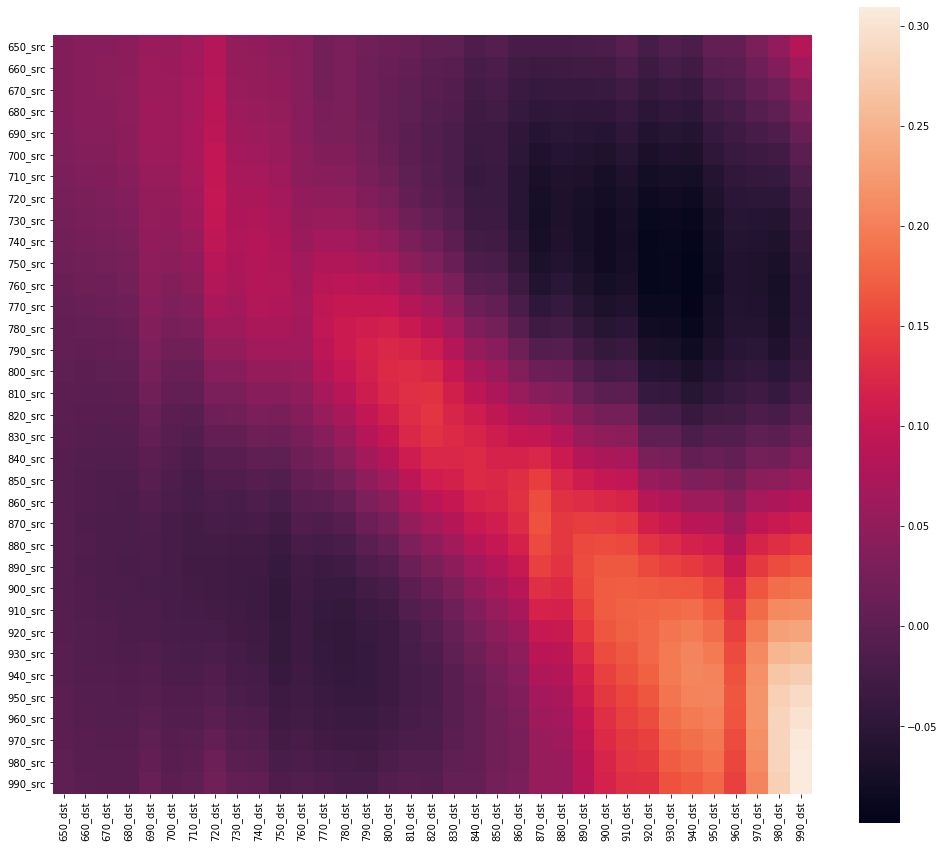

In [18]:
fig, ax = plt.subplots(figsize=(17, 15))

sns.heatmap(
    train_df.corr().loc["650_src":"990_src", "650_dst":"990_dst"],
    annot=False,
    square=True,
    ax=ax,
)

In [19]:
train_df.corr().loc["650_src":"990_src", "650_dst":"990_dst"]

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
650_src,0.034800,0.040927,0.041436,0.045216,0.058179,0.056547,0.065497,0.082676,0.052856,0.050566,...,-0.015461,-0.005535,-0.022289,-0.011971,-0.016962,0.006294,0.006598,0.030713,0.050650,0.082230
660_src,0.035105,0.041494,0.042147,0.046349,0.060022,0.058219,0.067391,0.084055,0.054239,0.051673,...,-0.026533,-0.016808,-0.031976,-0.022823,-0.027294,-0.005260,-0.001993,0.017931,0.034583,0.064443
670_src,0.035419,0.041782,0.042448,0.046958,0.060975,0.059751,0.069418,0.086135,0.056515,0.053670,...,-0.037280,-0.028143,-0.042109,-0.034449,-0.038518,-0.017450,-0.011891,0.003938,0.017131,0.045940
680_src,0.034503,0.041146,0.041971,0.046813,0.063079,0.060687,0.070300,0.089038,0.059587,0.057110,...,-0.046703,-0.037865,-0.051491,-0.044816,-0.048741,-0.028835,-0.020930,-0.008591,0.000874,0.028995
690_src,0.033111,0.039176,0.040139,0.045293,0.062996,0.060110,0.070699,0.091351,0.062393,0.059925,...,-0.056922,-0.048230,-0.061245,-0.055403,-0.059169,-0.039776,-0.029643,-0.020702,-0.013969,0.012819
700_src,0.031495,0.037185,0.038313,0.043809,0.061078,0.059698,0.070988,0.095300,0.066564,0.065053,...,-0.064723,-0.056372,-0.069395,-0.064271,-0.067738,-0.048274,-0.037106,-0.031352,-0.027064,-0.001383
710_src,0.028558,0.033689,0.035098,0.040530,0.056611,0.056959,0.069649,0.097206,0.070415,0.069513,...,-0.072773,-0.064461,-0.077658,-0.073224,-0.076995,-0.058238,-0.044772,-0.041812,-0.039717,-0.014680
720_src,0.025634,0.030387,0.031951,0.037005,0.054280,0.054571,0.067173,0.098706,0.074500,0.075168,...,-0.077392,-0.069716,-0.083910,-0.079930,-0.084453,-0.065686,-0.051207,-0.050191,-0.050204,-0.026358
730_src,0.022653,0.026900,0.028537,0.033438,0.052462,0.051170,0.063070,0.096781,0.075992,0.078975,...,-0.081308,-0.073783,-0.089233,-0.085557,-0.090422,-0.071243,-0.055775,-0.056644,-0.058698,-0.035586
740_src,0.019369,0.023435,0.025043,0.029626,0.050268,0.047250,0.057893,0.093593,0.077205,0.082696,...,-0.082003,-0.074931,-0.091914,-0.089301,-0.094444,-0.075926,-0.059562,-0.061329,-0.064605,-0.042093


In [20]:
train_df["rho"].sort_values()

9999    10
3834    10
9025    10
3837    10
9023    10
        ..
5433    25
5437    25
5447    25
5383    25
4999    25
Name: rho, Length: 10000, dtype: int64

In [21]:
train_df["rho"].value_counts()

25    2557
15    2509
20    2478
10    2456
Name: rho, dtype: int64

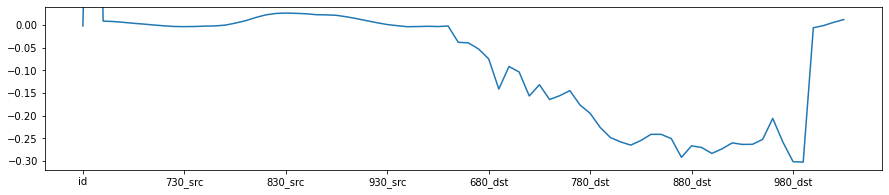

In [22]:
plt.figure(figsize=(15, 3))
ax = train_df.corr().loc["rho"].plot()
ax.set_ylim([-0.32, 0.04])
ax